In [1]:
import os
os.chdir(r"C:\Users\bdn18001\Documents\Git Local Copies\rapid-soh-estimation-from-short-pulses")

from rapid_soh_estimation.rapid_soh_estimation.config import *
from rapid_soh_estimation.rapid_soh_estimation.common_methods import *


cc_data = load_processed_data(data_type='cc')
pulse_data = load_processed_data(data_type='slowpulse')

c:\Users\bdn18001\anaconda3\envs\envRapidSOH\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def create_model(n_hlayers:int, n_neurons:int, act_fnc:str, opt_fnc:str, learning_rate:float, input_shape=(100,), output_shape=(7,)) -> keras.models.Sequential:
	"""Builds a Keras neural network model (MLP) using the specified parameters. The model is optimized for accuracy. Make sure model outputs (if multiple target) are normalized, otherwise optimization will be biased towards one target variable.

	Args:
		n_hlayers (int): Number of fully-connected hidden layers
		n_neurons (int): Number of neurons per hidden layer
		act_fnc (str): Activation function to use (\'tanh\', \'relu\', etc)
		opt_fnc (str): {\'sgd\', \'adam\'} Optimizer function to use 
		learning_rate (float): Learning rate
		input_shape (int, optional): Input shape of model. Defaults to (100,).
		output_shape (int, optional): Output shape of model. Default to (7,).
	Raises:
		ValueError: _description_

	Returns:
		keras.models.Sequential: compiled Keras model
	"""

	# add input layer to Sequential model
	model = keras.models.Sequential()
	model.add( keras.Input(shape=input_shape) )

	# add hidden layers
	for i in range(n_hlayers):
		model.add( keras.layers.Dense(units=n_neurons, activation=act_fnc) )
		
	# add output layer
	model.add( keras.layers.Dense(output_shape) )

	# compile model with chosen metrics
	opt = None
	if opt_fnc == 'adam':
		opt = keras.optimizers.Adam(learning_rate=learning_rate)
	elif opt_fnc == 'sgd':
		opt = keras.optimizers.SGD(learning_rate=learning_rate)
	else:
		raise ValueError("opt_func must be either \'adam\' or \'sgd\'")

	model.compile(
		optimizer=opt,
		loss=keras.losses.mean_squared_error,      
		# make sure to normalize all outputs, otherwise DCIR values will drastically skew MSE reading compared to error of predicted SOH
		metrics=['accuracy'] )
	return model

def loss_function(y_true, y_pred):
	"""The loss function used for all optuna studies

	Args:
		y_true (MatrixLike | ArrayLike): Ground truth (correct) target values
		y_pred (MatrixLike | ArrayLike): Estimated target values

	Returns:
		_type_: The loss for this prediction (ie, prediction error)
	"""

	loss = mean_squared_error(y_true, y_pred)
	return loss

class OptunaHyperParamOptimization:
	def __init__(self, X, y, splits, loss_fnc, random_state):
		self.X = X
		if len(self.X.shape) == 1: self.X = self.X.reshape(-1,1)
		self.y = y
		if len(self.y.shape) == 1: self.y = self.y.reshape(-1,1)
		self.splits = splits
		self.loss_fnc = loss_fnc
		self.random_state = random_state

	def __call__(self, trial:optuna.trial.Trial):
		return None

class OptunaHyperParamOptimization_MLP(OptunaHyperParamOptimization):
	def __call__(self, trial:optuna.trial.Trial):
		# average the loss over all cross-validation splits
		total_loss = 0
		iter_count = 0
		for train_idxs, test_idxs in self.splits:
			# get suggested parameter values from Optuna search space
			n_hlayers = trial.suggest_int('n_hlayers', 1, 5)
			n_neurons = trial.suggest_int('n_neurons', 4, 100)
			act_fnc = trial.suggest_categorical('act_fnc', ['linear','relu','sigmoid','softmax','softplus','tanh'])
			opt_fnc = trial.suggest_categorical('opt_fnc', ['adam', 'sgd'])
			learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)

			# create sequential NN model
			model = create_model(
				n_hlayers=n_hlayers,
				n_neurons=n_neurons,
				act_fnc=act_fnc,
				opt_fnc=opt_fnc,
				learning_rate=learning_rate,
				input_shape=self.X.shape[1],
				output_shape=self.y.shape[1]
			)

			# standardize input and output data (using only the training data to create the scaler)
			scaler_X = StandardScaler().fit(self.X[train_idxs])
			scaler_y = StandardScaler().fit(self.y[train_idxs])
			X_sc = scaler_X.transform(self.X)
			y_sc = scaler_y.transform(self.y)
   
			# fit model to scaled input and output data
			early_stop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=5, verbose=False, mode='auto', baseline=None, restore_best_weights=True)
			model.fit(
				X_sc[train_idxs], 
				y_sc[train_idxs],
				callbacks = early_stop, 
				verbose = 0)
			
			# get predictions
			y_pred_sc = model.predict(X_sc[test_idxs], verbose=0)

			# check if nan value exists in predictions (model failed to converge during traing)
			if not (len(np.where(y_pred_sc == np.nan)[0]) == 0) or not (len(np.where(y_pred_sc == None)[0]) == 0):
				continue
			# add loss to total
			total_loss += self.loss_fnc(y_sc[test_idxs], y_pred_sc)
			iter_count += 1

		# return average cross-validation loss
		return total_loss / iter_count

def print_optuna_study_results(study:optuna.Study):
	"""Prints the best loss and parameters for a given Optuna study"""
	
	print()
	print('*'*100)
	print(f'  Study: {study.study_name}')
	print('*'*100)
	print('  Best Loss: ', study.best_trial.value)
	print('  Best Params: ')
	for k,v in study.best_trial.params.items():
		print(f'    {k}: {v}')
	print('*'*100)
	print()

def perform_hyperparam_optimization(params:dict, dir_results:Path):
	for key,val in params.items():
		study = optuna.create_study(
			study_name=key,
			direction='minimize', 
			sampler=optuna.samplers.TPESampler(seed=random_state),)
		study.optimize(
			func = val['objective'],
			n_trials = val['n_trials'],
			n_jobs=-1)
		if val['save_results']:
			pickle.dump(
				study, 
				open(dir_results.joinpath(f"{val['filename']}.pkl"), 'wb'),
				protocol=pickle.HIGHEST_PROTOCOL)
		else:
			print_optuna_study_results(study)


### Optimize Model for Different Input Types (chg vs. dchg)

In [ ]:

all_data = deepcopy(pulse_data)
idxs = np.where((all_data['pulse_type'] == 'chg') & (all_data['soc'] == 20))
for k in all_data.keys():
	all_data[k] = all_data[k][idxs]
all_data['voltage_rel'] = np.asarray([v - v[0] for v in all_data['voltage']])
modeling_data = create_modeling_data(all_data=all_data, input_feature_keys=['voltage_rel'])
modeling_data['model_output'] = modeling_data['model_output'][:,0].reshape(-1,1)

random_state = 13
cv_splitter = Custom_CVSplitter(n_splits=3, split_type='group_id', rand_seed=random_state)
cv_splits = list(cv_splitter.split(
	X = modeling_data['model_input'], 
	y = modeling_data['model_output'], 
	cell_ids = modeling_data['cell_id']))

# key = study_name
hyperparam_opt_params = {
	'Hyperparameters_MLP_chg_onlySOH': {
		'objective':
			OptunaHyperParamOptimization_MLP(
				X=modeling_data['model_input'], 
				y=modeling_data['model_output'], 
				splits=cv_splits, 
				loss_fnc=loss_function, 
				random_state=random_state
			),
		'n_trials':1000,
		'save_results':True,
		'filename':'hyperparam_study_mlp_chg_onlySOH'
	},
}

dir_hyperparam_results = dir_repo_main.joinpath("results", 'hyperparameter_optimization')
dir_hyperparam_results.mkdir(exist_ok=True, parents=True)
perform_hyperparam_optimization(hyperparam_opt_params, dir_hyperparam_results)



In [ ]:
for p_type in ['dchg']: #, 'dchg']:
    for soc in [50,90]:
        # get modeling data (charge pulse only, all SOCs)
        all_data = deepcopy(pulse_data)
        idxs = np.where((all_data['pulse_type'] == p_type) & (all_data['soc'] == soc))
        for k in all_data.keys():
            all_data[k] = all_data[k][idxs]
        all_data['voltage_rel'] = np.asarray([v - v[0] for v in all_data['voltage']])
        modeling_data = create_modeling_data(all_data=all_data, input_feature_keys=['voltage_rel'])


        random_state = 13
        cv_splitter = Custom_CVSplitter(n_splits=3, split_type='group_id', rand_seed=random_state)
        cv_splits = list(cv_splitter.split(
            X = modeling_data['model_input'], 
            y = modeling_data['model_output'], 
            cell_ids = modeling_data['cell_id']))

        # key = study_name
        hyperparam_opt_params = {
            f'Hyperparameters_MLP_{p_type}_{soc}': {
                'objective':
                    OptunaHyperParamOptimization_MLP(
                        X=modeling_data['model_input'], 
                        y=modeling_data['model_output'], 
                        splits=cv_splits, 
                        loss_fnc=loss_function, 
                        random_state=random_state
                    ),
                'n_trials':1000,
                'save_results':True,
                'filename':f'hyperparam_study_mlp_{p_type}_{soc}'
            },
        }

        dir_hyperparam_results = dir_repo_main.joinpath("results", 'hyperparameter_optimization')
        dir_hyperparam_results.mkdir(exist_ok=True, parents=True)
        perform_hyperparam_optimization(hyperparam_opt_params, dir_hyperparam_results)


### Evalute Model Performance on OOD Test Cases

In [19]:
pulse_type = 'chg'
random_state = 1

for train_soc, test_socs in {20:[50,90], 50:[20,90], 90:[20,50]}.items():
    dir_hyperparam_results = Path(r"C:\Users\bdn18001\Documents\Git Local Copies\rapid-soh-estimation-from-short-pulses\results\hyperparameter_optimization")
    for file_study in dir_hyperparam_results.glob(f'*_mlp_{pulse_type}_{train_soc}.pkl'):
        # load optimal model from optimization results for this training SOC and pulse type
        study = pickle.load(open(file_study, 'rb'))
        model = create_model(**study.best_trial.params, output_shape=7)
        
        #region: get training data
        training_data = deepcopy(pulse_data)
        idxs = np.where((training_data['pulse_type'] == pulse_type) & (training_data['soc'] == train_soc))
        for k in training_data.keys():
            training_data[k] = training_data[k][idxs]
        training_data['voltage_rel'] = np.asarray([v - v[0] for v in training_data['voltage']])
        training_data = create_modeling_data(all_data=training_data, input_feature_keys=['voltage_rel'])
        #endregion
        
        #region: get train/test splits
        cv_splitter = Custom_CVSplitter(n_splits=3, split_type='group_id', rand_seed=random_state)
        cv_splits = list(cv_splitter.split(
            X = training_data['model_input'], 
            y = training_data['model_output'], 
            cell_ids = training_data['cell_id']))
        #endregion


        train_err_total = 0
        test_err_total = np.zeros(len(test_socs))
        for train_idxs, test_idxs in cv_splits:
            #region: fit model to data
            # standardize input and output data (using only the training data to create the scaler)
            scaler_X = StandardScaler().fit(training_data['model_input'][train_idxs])
            scaler_y = StandardScaler().fit(training_data['model_output'][train_idxs])
            training_data['model_input_scaled'] = scaler_X.transform(training_data['model_input'])
            training_data['model_output_scaled'] = scaler_y.transform(training_data['model_output'])
        
            # fit model to scaled input and output data
            early_stop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=5, verbose=False, mode='auto', baseline=None, restore_best_weights=True)
            model.fit(
                training_data['model_input_scaled'][train_idxs], 
                training_data['model_output_scaled'][train_idxs],
                callbacks = early_stop, 
                validation_split=0.1,
                verbose = 0)
            #endregion
        
            # get predictions
            train_yhat = model.predict(training_data['model_input_scaled'][test_idxs], verbose=0)
            train_err = mean_absolute_percentage_error(training_data['model_output_scaled'][test_idxs], train_yhat)
            train_err_total += train_err
            
            for i, test_soc in enumerate(test_socs):
                #region: get test data
                test_data = deepcopy(pulse_data)
                idxs = np.where((test_data['pulse_type'] == pulse_type) & (test_data['soc'] == test_soc))
                for k in test_data.keys():
                    test_data[k] = test_data[k][idxs]
                test_data['voltage_rel'] = np.asarray([v - v[0] for v in test_data['voltage']])
                test_data = create_modeling_data(all_data=test_data, input_feature_keys=['voltage_rel'])
                #endregion
                
                test_data['model_input_scaled'] = scaler_X.transform(test_data['model_input'])
                test_data['model_output_scaled'] = scaler_y.transform(test_data['model_output'])
                
                test_yhat = model.predict(test_data['model_input_scaled'][test_idxs], verbose=0)
                test_err = mean_absolute_percentage_error(test_data['model_output_scaled'][test_idxs], test_yhat)
                test_err_total[i] += test_err
                
                # print(f"Train SOC: {train_soc}\tTest SOC: {test_soc}")
                # print(f"  Train Error: {round(train_err, 4)}\tTest Error: {round(test_err, 4)}")
                
        train_err_total /= len(cv_splits)
        for i in range(len(test_err_total)):
            test_err_total[i] /= len(cv_splits)
            
        print(f"Train SOC: {train_soc}\t Train Error: {round(train_err_total, 4)}")
        for i, test_soc in enumerate(test_socs):
            print(f"  Test SOC: {test_soc}\t Test Error: {round(test_err_total[i], 4)}")
        


Train SOC: 20	 Train Error: 1.8017
  Test SOC: 50	 Test Error: 9.9598
  Test SOC: 90	 Test Error: 11.0829
Train SOC: 50	 Train Error: 1.9086
  Test SOC: 20	 Test Error: 17.0002
  Test SOC: 90	 Test Error: 16.5
Train SOC: 90	 Train Error: 3.1765
  Test SOC: 20	 Test Error: 3.6639
  Test SOC: 50	 Test Error: 10.3683


In [7]:
temp_data = deepcopy(pulse_data)
#region: get training data
idxs = np.where((temp_data['pulse_type'] == 'chg') & (np.isin(temp_data['soc'], [50,90])))
#endregion

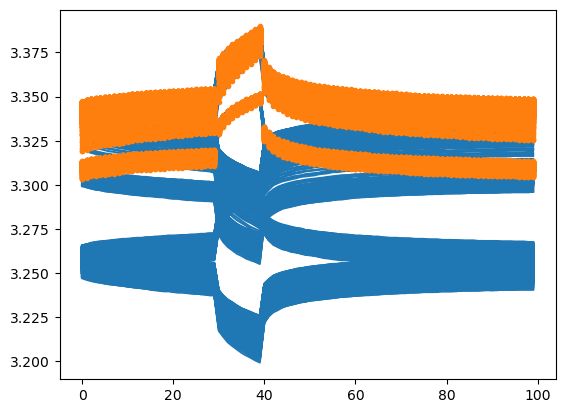

In [9]:
plt.plot(temp_data['voltage'].T, c='C0')
plt.plot(temp_data['voltage'][idxs].T, '.', c='C1')
plt.show()